In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
import time
from tqdm import tqdm
import math

In [11]:
# Set random seed for reproducibility
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Constants
NUM_CLASSES = 10
BATCH_SIZE = 100
NUM_EPOCHS = 5  # Keep low for faster training
LEARNING_RATE = 0.001

# Data preprocessing
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


Using device: cuda


In [12]:
# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [13]:
# Model Architectures

# 1. Basic CNN
class BasicCNN(nn.Module):
    def __init__(self):
        super(BasicCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, NUM_CLASSES)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


In [14]:
# 2. ResNet50 (simplified for CIFAR-10)
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * self.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * self.expansion)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


In [15]:
# 3. AlexNet (adapted for CIFAR-10)
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 4 * 4, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


In [16]:
# 4. DenseNet (simplified for CIFAR-10)
class Bottleneck_DenseNet(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super(Bottleneck_DenseNet, self).__init__()
        inner_channels = 4 * growth_rate
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(in_channels, inner_channels, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(inner_channels)
        self.conv2 = nn.Conv2d(inner_channels, growth_rate, kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        out = self.conv1(F.relu(self.bn1(x)))
        out = self.conv2(F.relu(self.bn2(out)))
        out = torch.cat([x, out], 1)
        return out

class Transition(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Transition, self).__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.pool = nn.AvgPool2d(2, stride=2)

    def forward(self, x):
        out = self.conv(F.relu(self.bn(x)))
        out = self.pool(out)
        return out

class DenseNet(nn.Module):
    def __init__(self, block, num_blocks, growth_rate=12, reduction=0.5, num_classes=10):
        super(DenseNet, self).__init__()
        self.growth_rate = growth_rate

        num_channels = 2 * growth_rate
        self.conv1 = nn.Conv2d(3, num_channels, kernel_size=3, padding=1, bias=False)

        self.dense1 = self._make_dense_layers(block, num_channels, num_blocks[0])
        num_channels += num_blocks[0] * growth_rate
        out_channels = int(math.floor(num_channels * reduction))
        self.trans1 = Transition(num_channels, out_channels)
        num_channels = out_channels

        self.dense2 = self._make_dense_layers(block, num_channels, num_blocks[1])
        num_channels += num_blocks[1] * growth_rate
        out_channels = int(math.floor(num_channels * reduction))
        self.trans2 = Transition(num_channels, out_channels)
        num_channels = out_channels

        self.dense3 = self._make_dense_layers(block, num_channels, num_blocks[2])
        num_channels += num_blocks[2] * growth_rate
        out_channels = int(math.floor(num_channels * reduction))
        self.trans3 = Transition(num_channels, out_channels)
        num_channels = out_channels

        self.dense4 = self._make_dense_layers(block, num_channels, num_blocks[3])
        num_channels += num_blocks[3] * growth_rate

        self.bn = nn.BatchNorm2d(num_channels)
        self.linear = nn.Linear(num_channels, num_classes)

    def _make_dense_layers(self, block, in_channels, num_blocks):
        layers = []
        for i in range(num_blocks):
            layers.append(block(in_channels, self.growth_rate))
            in_channels += self.growth_rate
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.trans1(self.dense1(out))
        out = self.trans2(self.dense2(out))
        out = self.trans3(self.dense3(out))
        out = self.dense4(out)
        out = F.avg_pool2d(F.relu(self.bn(out)), 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def DenseNet121():
    return DenseNet(Bottleneck_DenseNet, [6, 12, 24, 16], growth_rate=32)



In [17]:
# 5. VGG16 (adapted for CIFAR-10)
class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x




In [18]:
# Training and Evaluation Functions
def train(model, train_loader, optimizer, criterion, epoch, model_name):
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1} - Training {model_name}")
    for batch_idx, (data, target) in pbar:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

        pbar.set_postfix({'loss': train_loss/(batch_idx+1), 'acc': 100.*correct/total})

    return train_loss/len(train_loader), 100.*correct/total

def test(model, test_loader, criterion, model_name):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        pbar = tqdm(enumerate(test_loader), total=len(test_loader), desc=f"Testing {model_name}")
        for batch_idx, (data, target) in pbar:
            data, target = data.to(device), target.to(device)

            output = model(data)
            loss = criterion(output, target)

            test_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

            pbar.set_postfix({'loss': test_loss/(batch_idx+1), 'acc': 100.*correct/total})

    return test_loss/len(test_loader), 100.*correct/total, all_preds, all_targets

def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.savefig(f'{model_name}_confusion_matrix.png')
    plt.show()


In [19]:
# Training all models and collecting metrics
def train_and_evaluate_model(model_class, model_name):
    print(f"\nTraining {model_name}...")
    model = model_class().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []

    start_time = time.time()

    for epoch in range(NUM_EPOCHS):
        train_loss, train_acc = train(model, train_loader, optimizer, criterion, epoch, model_name)
        test_loss, test_acc, _, _ = test(model, test_loader, criterion, model_name)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

    training_time = time.time() - start_time
    print(f"Total training time for {model_name}: {training_time:.2f} seconds")

    # Generate confusion matrix
    _, _, all_preds, all_targets = test(model, test_loader, criterion, model_name)
    plot_confusion_matrix(all_targets, all_preds, model_name)

    return {
        'model_name': model_name,
        'train_losses': train_losses,
        'train_accs': train_accs,
        'test_losses': test_losses,
        'test_accs': test_accs,
        'final_test_acc': test_accs[-1],
        'training_time': training_time
    }

In [20]:
# Define models to train
models = [
    (BasicCNN, "Basic CNN"),
    (ResNet50, "ResNet50"),
    (AlexNet, "AlexNet"),
    (DenseNet121, "DenseNet121"),
    (VGG16, "VGG16")
]


Training Basic CNN...


Testing Basic CNN: 100%|██████████| 100/100 [00:02<00:00, 43.28it/s, loss=1.07, acc=61.5]

Epoch 1: Train Loss: 1.4602, Train Acc: 46.48%, Test Loss: 1.0652, Test Acc: 61.46%



Testing Basic CNN: 100%|██████████| 100/100 [00:02<00:00, 43.12it/s, loss=1, acc=64]

Epoch 2: Train Loss: 1.1154, Train Acc: 60.07%, Test Loss: 1.0004, Test Acc: 63.95%



Testing Basic CNN: 100%|██████████| 100/100 [00:03<00:00, 31.39it/s, loss=0.906, acc=68]


Epoch 3: Train Loss: 0.9906, Train Acc: 64.83%, Test Loss: 0.9057, Test Acc: 67.98%


Testing Basic CNN: 100%|██████████| 100/100 [00:02<00:00, 42.78it/s, loss=0.775, acc=73]


Epoch 4: Train Loss: 0.9137, Train Acc: 67.81%, Test Loss: 0.7748, Test Acc: 72.95%


Testing Basic CNN: 100%|██████████| 100/100 [00:04<00:00, 23.63it/s, loss=0.791, acc=71.3]

Epoch 5: Train Loss: 0.8585, Train Acc: 70.03%, Test Loss: 0.7911, Test Acc: 71.29%
Total training time for Basic CNN: 113.46 seconds



Testing Basic CNN: 100%|██████████| 100/100 [00:04<00:00, 20.20it/s, loss=0.791, acc=71.3]


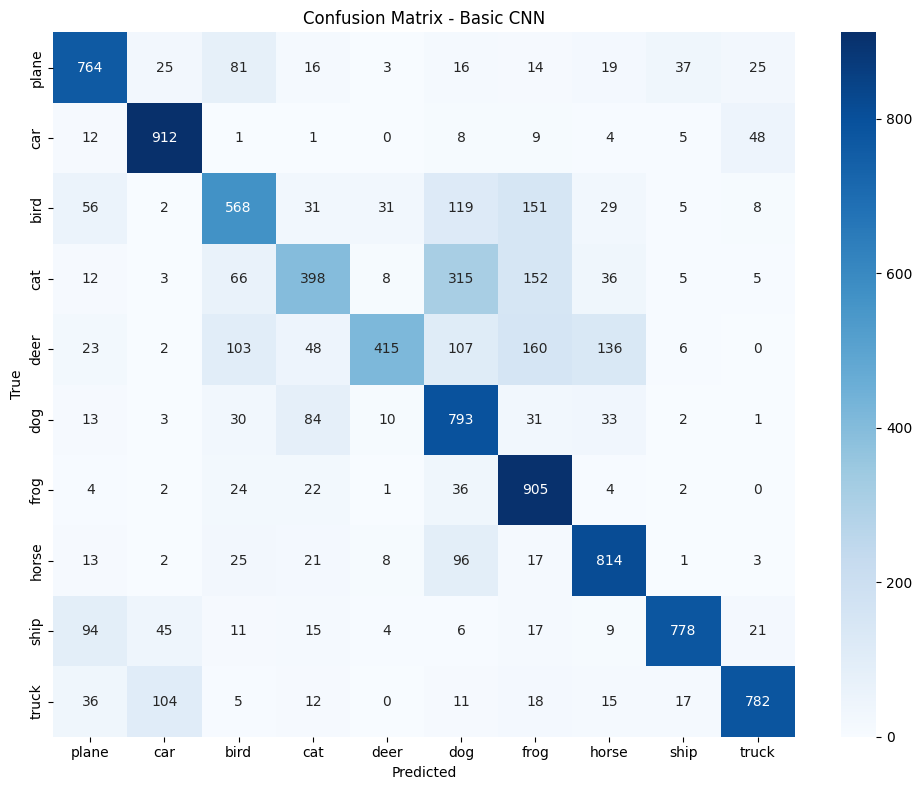


Training ResNet50...


Testing ResNet50: 100%|██████████| 100/100 [00:09<00:00, 10.36it/s, loss=1.4, acc=51.2]

Epoch 1: Train Loss: 1.6271, Train Acc: 40.49%, Test Loss: 1.4023, Test Acc: 51.17%



Testing ResNet50: 100%|██████████| 100/100 [00:09<00:00, 10.36it/s, loss=1.36, acc=55.1]

Epoch 2: Train Loss: 1.0818, Train Acc: 61.16%, Test Loss: 1.3581, Test Acc: 55.08%



Testing ResNet50: 100%|██████████| 100/100 [00:09<00:00, 10.38it/s, loss=0.89, acc=69.4]

Epoch 3: Train Loss: 0.8586, Train Acc: 69.71%, Test Loss: 0.8897, Test Acc: 69.39%



Testing ResNet50: 100%|██████████| 100/100 [00:09<00:00, 10.34it/s, loss=0.709, acc=76.1]

Epoch 4: Train Loss: 0.7154, Train Acc: 74.92%, Test Loss: 0.7090, Test Acc: 76.13%



Testing ResNet50: 100%|██████████| 100/100 [00:09<00:00, 10.25it/s, loss=0.849, acc=75.3]

Epoch 5: Train Loss: 0.6188, Train Acc: 78.43%, Test Loss: 0.8491, Test Acc: 75.27%
Total training time for ResNet50: 911.49 seconds



Testing ResNet50: 100%|██████████| 100/100 [00:09<00:00, 10.24it/s, loss=0.849, acc=75.3]


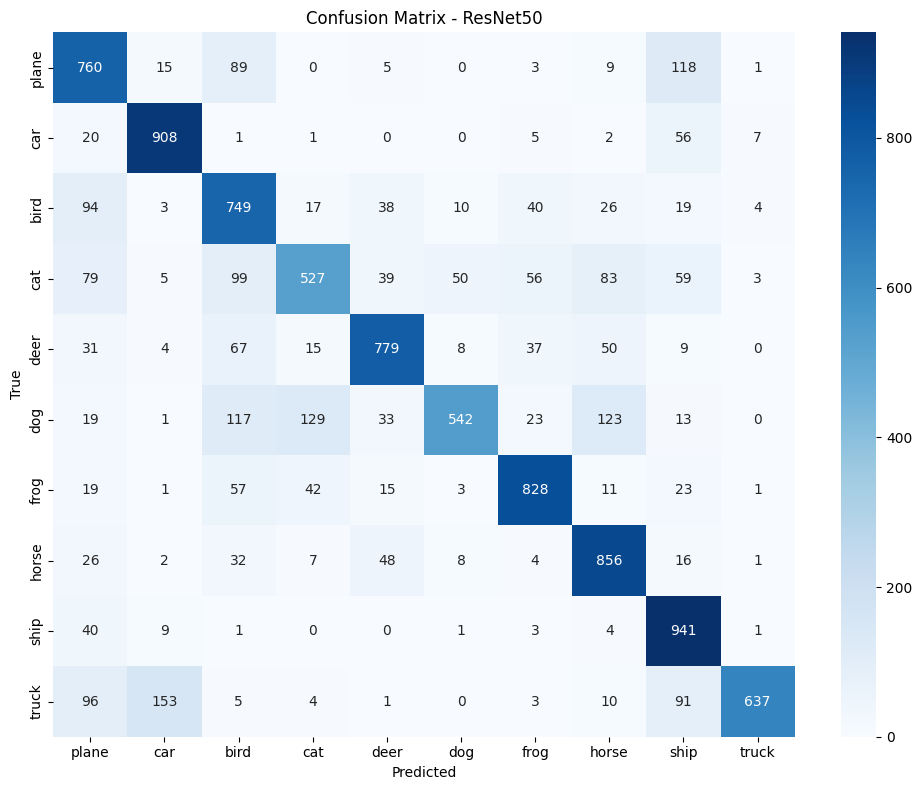


Training AlexNet...


Testing AlexNet: 100%|██████████| 100/100 [00:02<00:00, 36.12it/s, loss=1.36, acc=49.7]

Epoch 1: Train Loss: 1.7345, Train Acc: 34.56%, Test Loss: 1.3606, Test Acc: 49.67%



Testing AlexNet: 100%|██████████| 100/100 [00:02<00:00, 36.76it/s, loss=1.15, acc=59]

Epoch 2: Train Loss: 1.3426, Train Acc: 51.34%, Test Loss: 1.1481, Test Acc: 59.00%



Testing AlexNet: 100%|██████████| 100/100 [00:02<00:00, 36.55it/s, loss=1.01, acc=63.8]

Epoch 3: Train Loss: 1.1737, Train Acc: 58.49%, Test Loss: 1.0079, Test Acc: 63.83%



Testing AlexNet: 100%|██████████| 100/100 [00:02<00:00, 37.19it/s, loss=0.912, acc=68.1]


Epoch 4: Train Loss: 1.0622, Train Acc: 62.47%, Test Loss: 0.9124, Test Acc: 68.08%


Testing AlexNet: 100%|██████████| 100/100 [00:02<00:00, 37.81it/s, loss=0.907, acc=68.5]

Epoch 5: Train Loss: 0.9820, Train Acc: 65.51%, Test Loss: 0.9070, Test Acc: 68.54%
Total training time for AlexNet: 134.36 seconds



Testing AlexNet: 100%|██████████| 100/100 [00:03<00:00, 26.86it/s, loss=0.907, acc=68.5]


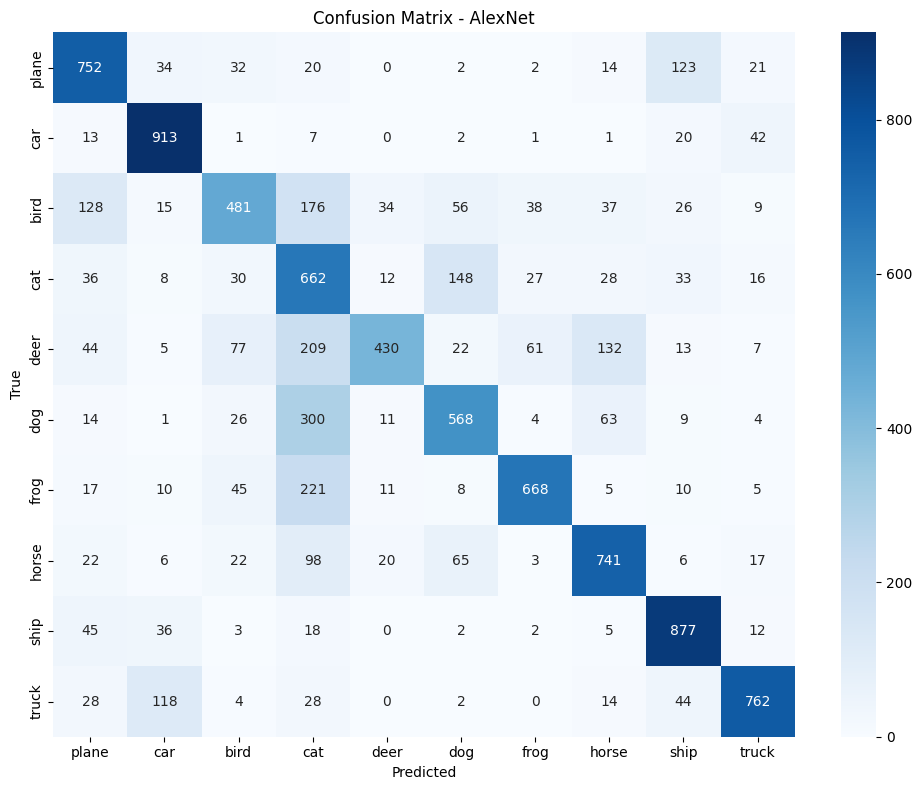


Training DenseNet121...


Testing DenseNet121: 100%|██████████| 100/100 [00:12<00:00,  8.25it/s, loss=1.14, acc=60.8]

Epoch 1: Train Loss: 1.3728, Train Acc: 49.46%, Test Loss: 1.1361, Test Acc: 60.82%



Testing DenseNet121: 100%|██████████| 100/100 [00:12<00:00,  8.25it/s, loss=0.921, acc=68.8]

Epoch 2: Train Loss: 0.8945, Train Acc: 68.19%, Test Loss: 0.9212, Test Acc: 68.77%



Testing DenseNet121: 100%|██████████| 100/100 [00:12<00:00,  8.30it/s, loss=0.707, acc=76.4]

Epoch 3: Train Loss: 0.6798, Train Acc: 76.25%, Test Loss: 0.7070, Test Acc: 76.41%



Testing DenseNet121: 100%|██████████| 100/100 [00:12<00:00,  8.28it/s, loss=0.679, acc=77.7]

Epoch 4: Train Loss: 0.5434, Train Acc: 81.03%, Test Loss: 0.6786, Test Acc: 77.66%



Testing DenseNet121: 100%|██████████| 100/100 [00:12<00:00,  8.30it/s, loss=0.467, acc=84.1]

Epoch 5: Train Loss: 0.4683, Train Acc: 83.68%, Test Loss: 0.4666, Test Acc: 84.08%
Total training time for DenseNet121: 906.34 seconds



Testing DenseNet121: 100%|██████████| 100/100 [00:12<00:00,  8.32it/s, loss=0.467, acc=84.1]


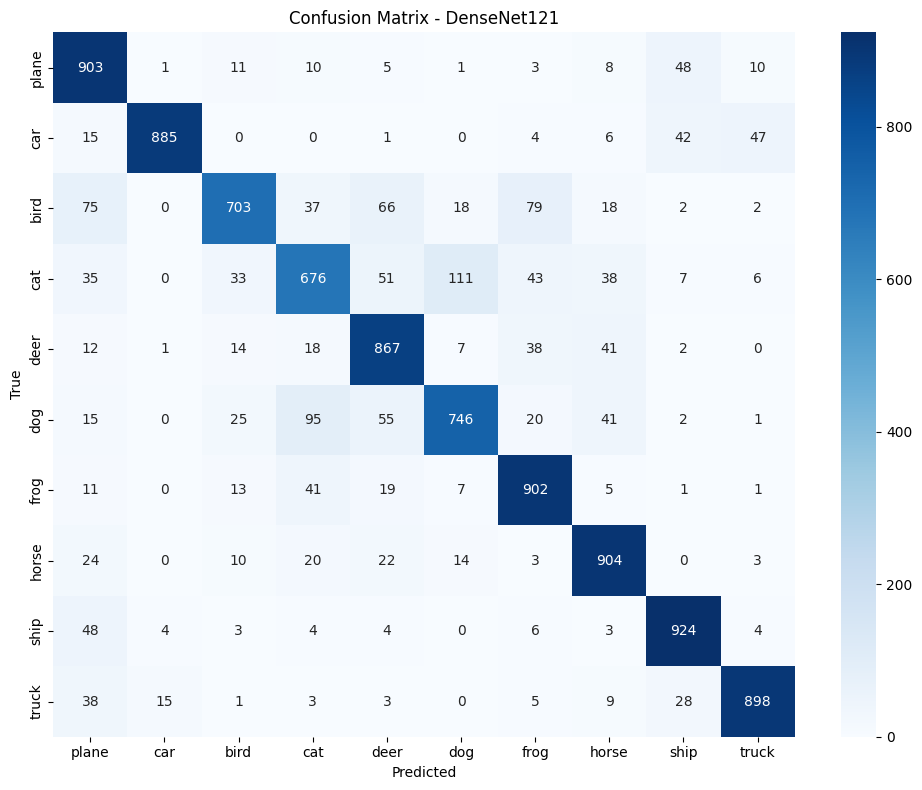


Training VGG16...


Testing VGG16: 100%|██████████| 100/100 [00:03<00:00, 32.48it/s, loss=1.82, acc=25.9]

Epoch 1: Train Loss: 1.9293, Train Acc: 20.80%, Test Loss: 1.8223, Test Acc: 25.86%



Testing VGG16: 100%|██████████| 100/100 [00:03<00:00, 32.04it/s, loss=1.74, acc=36]

Epoch 2: Train Loss: 1.6912, Train Acc: 31.17%, Test Loss: 1.7355, Test Acc: 35.97%



Testing VGG16: 100%|██████████| 100/100 [00:04<00:00, 23.77it/s, loss=1.41, acc=46]

Epoch 3: Train Loss: 1.4375, Train Acc: 43.39%, Test Loss: 1.4114, Test Acc: 45.96%



Testing VGG16: 100%|██████████| 100/100 [00:03<00:00, 32.55it/s, loss=1.22, acc=56.8]


Epoch 4: Train Loss: 1.2299, Train Acc: 54.85%, Test Loss: 1.2203, Test Acc: 56.76%


Testing VGG16: 100%|██████████| 100/100 [00:03<00:00, 29.19it/s, loss=1.19, acc=60]

Epoch 5: Train Loss: 1.0643, Train Acc: 61.72%, Test Loss: 1.1870, Test Acc: 59.95%
Total training time for VGG16: 166.28 seconds



Testing VGG16: 100%|██████████| 100/100 [00:03<00:00, 27.99it/s, loss=1.19, acc=60]


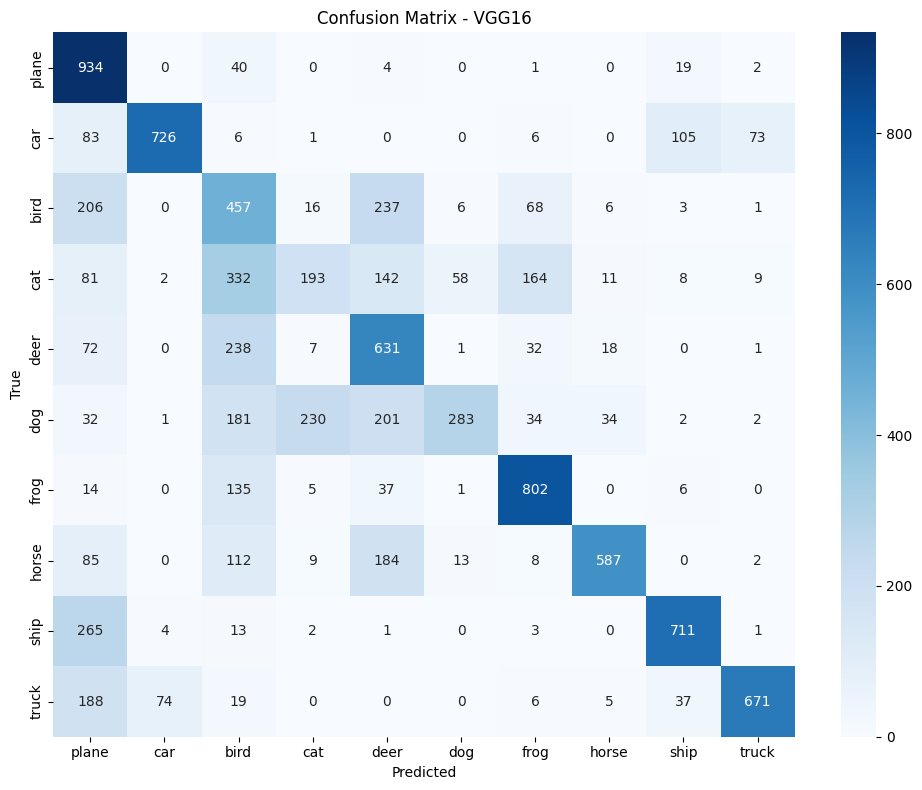

In [21]:
# Train and evaluate all models
results = []
for model_class, model_name in models:
    result = train_and_evaluate_model(model_class, model_name)
    results.append(result)

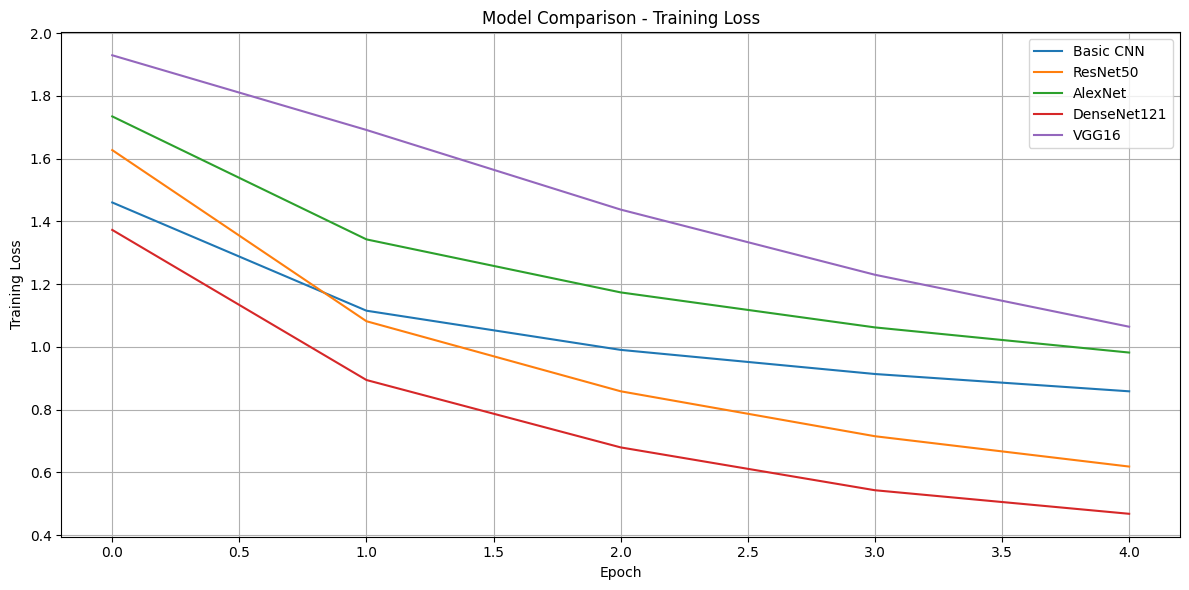

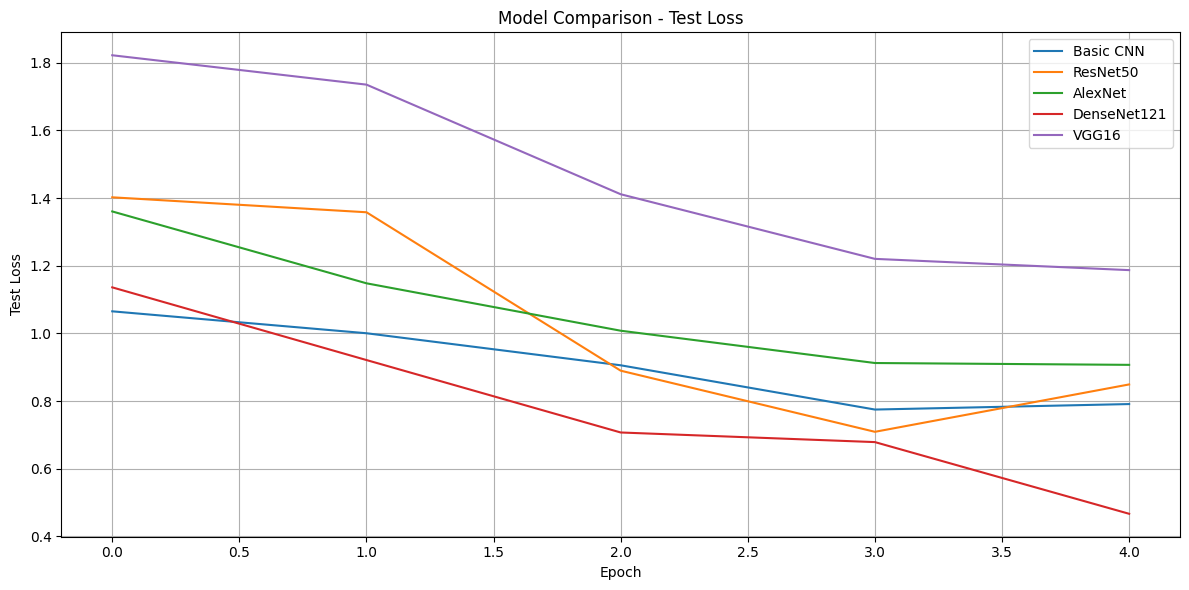

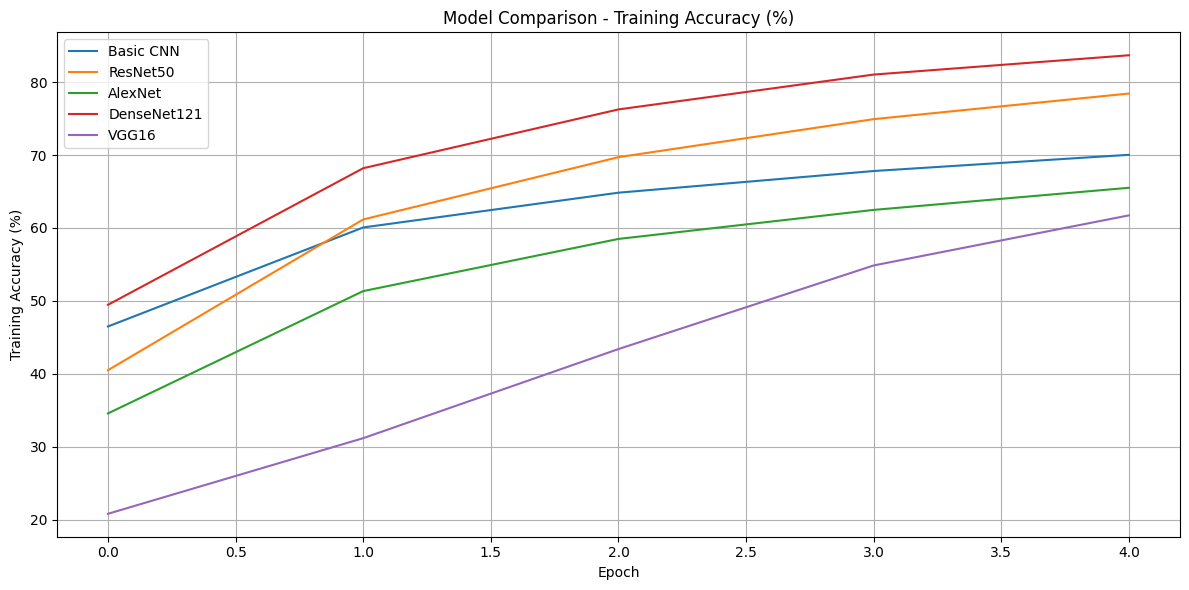

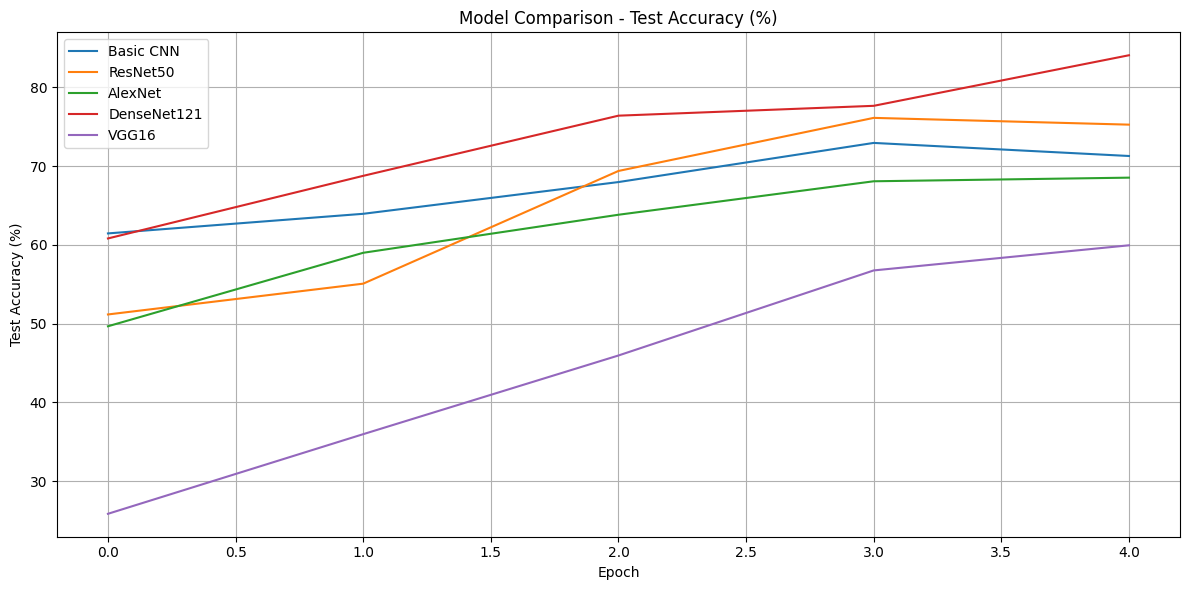

In [22]:
# Plot comparison charts
def plot_metric_comparison(results, metric_name, ylabel):
    plt.figure(figsize=(12, 6))
    for result in results:
        plt.plot(result[metric_name], label=result['model_name'])
    plt.title(f'Model Comparison - {ylabel}')
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'comparison_{metric_name}.png')
    plt.show()

plot_metric_comparison(results, 'train_losses', 'Training Loss')
plot_metric_comparison(results, 'test_losses', 'Test Loss')
plot_metric_comparison(results, 'train_accs', 'Training Accuracy (%)')
plot_metric_comparison(results, 'test_accs', 'Test Accuracy (%)')

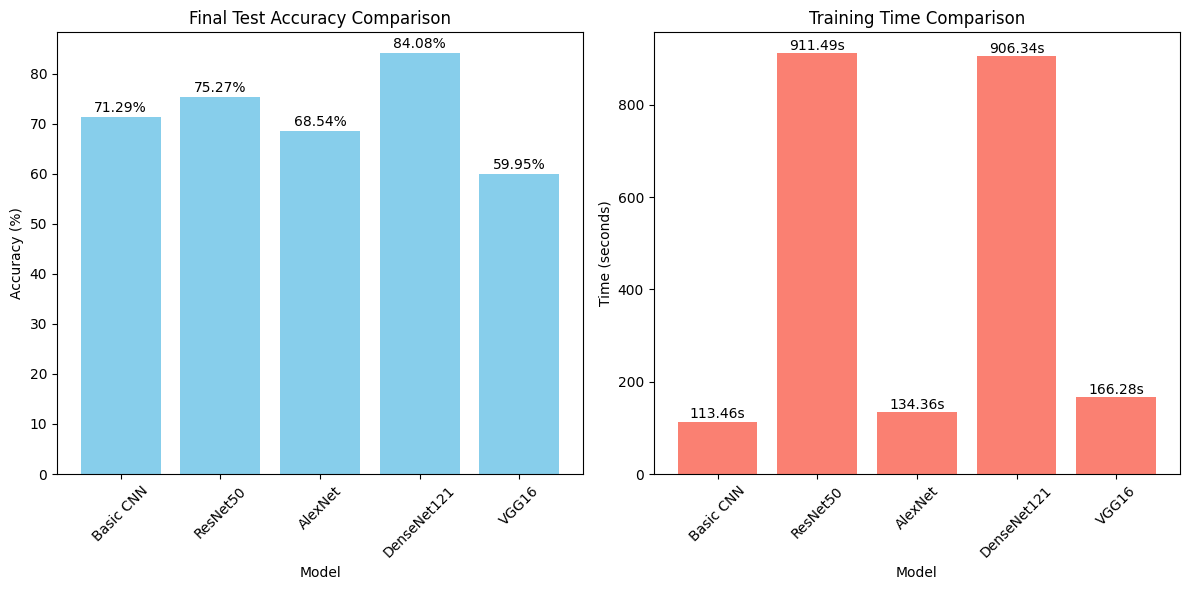


Final Test Accuracy Summary:
Basic CNN: 71.29%, Training Time: 113.46s
ResNet50: 75.27%, Training Time: 911.49s
AlexNet: 68.54%, Training Time: 134.36s
DenseNet121: 84.08%, Training Time: 906.34s
VGG16: 59.95%, Training Time: 166.28s


In [23]:
# Plot final test accuracy comparison
plt.figure(figsize=(12, 6))
model_names = [result['model_name'] for result in results]
final_accs = [result['final_test_acc'] for result in results]
training_times = [result['training_time'] for result in results]

plt.subplot(1, 2, 1)
bars = plt.bar(model_names, final_accs, color='skyblue')
plt.title('Final Test Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy (%)')
plt.xticks(rotation=45)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{height:.2f}%', ha='center', va='bottom')

plt.subplot(1, 2, 2)
bars = plt.bar(model_names, training_times, color='salmon')
plt.title('Training Time Comparison')
plt.xlabel('Model')
plt.ylabel('Time (seconds)')
plt.xticks(rotation=45)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{height:.2f}s', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('final_comparison.png')
plt.show()

print("\nFinal Test Accuracy Summary:")
for result in results:
    print(f"{result['model_name']}: {result['final_test_acc']:.2f}%, Training Time: {result['training_time']:.2f}s")